In [1]:
import iris
import os
import fnmatch
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
rain = xr.open_dataarray('data/hr_summer_precip.nc')

In [3]:
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from scipy.misc import toimage

class PrecipDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, array, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.array = array
        self.transform = transform

    def __len__(self):
        return len(self.array)

    def __getitem__(self, idx):
        sample = self.array[idx]
        img = toimage(sample.data)

        if self.transform:
            img = self.transform(img)

        return img, img

In [4]:
230708 / 4000

57.677

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

args_dict = {'batch_size': 5,
             'epochs': 20,
             'cuda': False,
             'seed': 1,
             'log_interval': 10}
args = type('test', (object,), {})()
args.__dict__.update(args_dict)


torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)


kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=args.batch_size, shuffle=True, **kwargs)

train_loader = torch.utils.data.DataLoader(PrecipDataset(rain[:-10], transform=transforms.ToTensor()),
                                           batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(PrecipDataset(rain[-10:], transform=transforms.ToTensor()),
                                          batch_size=args.batch_size, shuffle=True, **kwargs)

N = 230708
# n2 = int(N/200)
# n3 = int(N/4000)
n2 = 1600
n3 = 100

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(N, n2)
        self.fc21 = nn.Linear(n2, n3)
        self.fc22 = nn.Linear(n2, n3)
        self.fc3 = nn.Linear(n3, n2)
        self.fc4 = nn.Linear(n2, N)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def encode(self, x):
        h1 = self.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, N))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
if args.cuda:
    model.cuda()


def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, N))

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= args.batch_size * N

    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        print(batch_idx)
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    for i, (data, _) in enumerate(test_loader):
        if args.cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]
        if i == 0:
            n = min(data.size(0), 8)
            comparison = torch.cat([data[:n],
                                  recon_batch.view(args.batch_size, 1, 548, 421)[:n]])
            save_image(comparison.data.cpu(),
                     'results/reconstruction_' + str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)
    sample = Variable(torch.randn(64, n3))
    if args.cuda:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()
    save_image(sample.data.view(64, 1, 548, 421),
               'results/sample_' + str(epoch) + '.png')

0
Train Epoch: 1 [0/242 (0%)]	Loss: 0.138891
1
2
3
4
5
6
7
8
9
10
Train Epoch: 1 [50/242 (20%)]	Loss: 18.136002
11
12
13
14
15
16
17
18
19
20
Train Epoch: 1 [100/242 (41%)]	Loss: 0.066799
21
22
23
24
25
26
27
28
29
30
Train Epoch: 1 [150/242 (61%)]	Loss: 0.031608
31
32
33
34
35
36
37
38
39
40
Train Epoch: 1 [200/242 (82%)]	Loss: 0.090762
41
42
43
44
45
46
47
48
====> Epoch: 1 Average loss: 0.7725
====> Test set loss: 0.0368
0
Train Epoch: 2 [0/242 (0%)]	Loss: 0.043081
1
2
3
4
5
6
7
8
9
10
Train Epoch: 2 [50/242 (20%)]	Loss: 0.015291
11
12
13
14
15
16
17
18
19
20
Train Epoch: 2 [100/242 (41%)]	Loss: 0.054555
21
22
23
24
25
26
27
28
29
30
Train Epoch: 2 [150/242 (61%)]	Loss: 0.040317
31
32
33
34
35
36
37
38
39
40
Train Epoch: 2 [200/242 (82%)]	Loss: 0.023405
41
42
43
44
45
46
47
48
====> Epoch: 2 Average loss: 0.0352
====> Test set loss: 0.0339
0
Train Epoch: 3 [0/242 (0%)]	Loss: 0.058134
1
2
3
4
5
6
7
8
9
10
Train Epoch: 3 [50/242 (20%)]	Loss: 0.019156
11
12
13
14
15
16
17
18
19
20
Trai

In [7]:
import gc
gc.collect()

1804

In [10]:
28*28

784

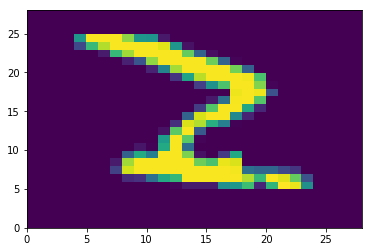

In [45]:
plt.pcolormesh(t.numpy()[0])

In [49]:
30*30

900

In [14]:
548 * 421

230708